# Image and Video Support in Lhotse

This notebook demonstrates how to work with image and video data in Lhotse. We'll cover:

1.  **Working with Images**
    *   Preparing example images with corresponding audio and transcriptions
    *   Creating `MonoCut` with `Recording`, `Image`, and `SupervisionSegment`
    *   Saving to JSONL format
    *   Loading data items
    *   Building a `DynamicCutSampler` and dataloader for image+audio+text
2.  **Working with Videos**
    *   Preparing example video with captions
    *   Creating `MonoCut` with `Recording` (including `VideoInfo`), and `SupervisionSegment`
    *   Saving to JSONL format
    *   Loading data items (including video frames)
    *   Building a `DynamicCutSampler` and dataloader for video+text

Let's get started!

In [1]:
# Install optional dependencies for this notebook
# !pip install -qU moviepy gtts pillow torch torchaudio torchvision matplotlib scipy 
# !pip install -qU lhotse # Uncomment if you haven't installed Lhotse

# Import required libraries
import os
import random
import tempfile
import urllib.request
import textwrap
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
import torchaudio
from IPython.display import Audio, display, Image as IPythonImage, Video
from PIL import Image as PILImage, ImageDraw, ImageFont
from gtts import gTTS
from moviepy import TextClip, CompositeVideoClip
from tqdm.auto import tqdm

import lhotse
from lhotse import CutSet, MonoCut, Recording, SupervisionSegment
from lhotse.audio.source import VideoInfo
from lhotse.dataset import DynamicCutSampler, VadDataset
#from lhotse.dataset.dataloading import make_dataloader
from lhotse.image.image import Image # Lhotse's Image manifest
from lhotse.image.io import PillowWriter # For saving images if needed, though attach_image handles paths directly

# Set up a directory for storing example data
EXAMPLE_ROOT = Path("data/synth-audio-image-video-caption")
EXAMPLE_ROOT.mkdir(parents=True, exist_ok=True)

print(f"Lhotse version: {lhotse.__version__}")

Lhotse version: 1.30.3.dev+git.8af32e47.dirty


/Users/pzelasko/miniforge3/envs/lhotse4/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 0. Preparing synthetic dataset

In order to demonstrate Lhotse's capabilities with images and videos, we start by building a 10 example synthetic dataset.
It consists of the following data:

* `sample-id.txt` - contains an English random text caption.
* `sample-id.wav` - contains synthesized speech corresponding to the caption.
* `sample-id.jpg` - contains an image with the rendered text caption.
* `sample-id.mp4` - contains an video with the rendered text caption, word-by-word, changing every 100ms.

It requires installing extra dependencies `gtts`, `pillow`, and `moviepy` to generate this data.

The videos do not contain an audio channel to limit the complexity of this example; however, loading audio+video together is fully supported by lhotse.

Feel free to skip the generation code below and jump directly into lhotse-related part of the tutorial.

In [2]:
def generate_text_video(text, filename, duration_per_word=0.1, fontsize=50, 
                        color='white', bg_color='black', size=(640, 480)):
    words = text.split()
    clips = []
    start_time = 0
    
    for i in range(len(words)):
        # Create a clip for the first i+1 words
        current_text = ' '.join(words[:i+1])
        txt_clip = TextClip(text=current_text, font_size=fontsize, color=color, 
                           size=size, bg_color=bg_color, method='caption')
        txt_clip = txt_clip.with_start(start_time).with_duration(duration_per_word)
        clips.append(txt_clip)
        start_time += duration_per_word
    
    video = CompositeVideoClip(clips, size=size).with_duration(duration_per_word * len(words))
    video.write_videofile(filename, fps=24, logger=None)


# Function to generate JPEG image with the given text caption
def generate_image_with_text(text, filename='output.jpg', width=800, height=400, bg_color='white', text_color='black', font_path=None, font_size=24):
    # Create a blank image with specified background color
    image = PILImage.new('RGB', (width, height), color=bg_color)
    draw = ImageDraw.Draw(image)

    # Load a font. Uses default if no path is provided.
    if font_path is None:
        font = ImageFont.load_default()
    else:
        font = ImageFont.truetype(font_path, font_size)

    # Wrap text to fit within the image width
    margin = 20
    # Calculates the maximum width for text, considering a margin of 20px on each side
    # The textwrap.wrap function will break the text into lines that fit this width.
    # The 'width=40' parameter in textwrap.wrap is an approximate number of characters per line.
    # This might need adjustment depending on the fonts desired appearance.
    lines = textwrap.wrap(text, width=40)

    # Calculate the height of a single line of text and total text block height
    # font.getbbox('A') returns (left, top, right, bottom) bounding box for 'A'
    # line_height is calculated as bottom - top
    bbox_char = font.getbbox('A') # Get bounding box for a character to estimate line height
    line_height = bbox_char[3] - bbox_char[1]
    total_text_height = line_height * len(lines)

    # Calculate starting y position to center the text vertically
    y_text = (height - total_text_height) // 2

    # Draw each line of text
    for line in lines:
        # font.getbbox(line) returns (left, top,right, bottom) for the line
        # line_width is calculated as right - left
        bbox_line = font.getbbox(line)
        line_width = bbox_line[2] - bbox_line[0]
        # Calculate x position to center the line horizontally
        x_text = (width - line_width) // 2
        draw.text((x_text, y_text), line, font=font, fill=text_color)
        y_text += line_height # Move to the next line position

    # Save the image as JPEG
    image.save(filename, 'JPEG')
    return filename


# Function to generate a speech recording from the given text caption using gTTS
def generate_speech_from_text(text, filename='output_speech.mp3'):
    # Initialize gTTS with the text and language (English)
    tts = gTTS(text=text, lang='en')
    # Save the speech to an MP3 file
    tts.save(filename)
    return filename

    
def generate_random_sentence(max_words=10):
    nouns = ["cat", "dog", "person", "computer", "tree", "book", "city", "car", "house", "phone"]
    verbs = ["runs", "jumps", "talks", "reads", "writes", "watches", "creates", "builds", "drives", "sees"]
    adjectives = ["happy", "big", "small", "blue", "green", "smart", "fast", "slow", "tall", "short"]
    adverbs = ["quickly", "slowly", "carefully", "loudly", "quietly", "suddenly", "happily", "sadly", "easily"]
    words = random.sample(nouns + verbs + adjectives + adverbs, min(max_words, len(nouns + verbs + adjectives + adverbs)))
    return " ".join(words[:max_words]).capitalize() + "."


def generate_synthetic_dataset(output_dir: str, size: int = 100):
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)

    for i in tqdm(range(size), desc="Building dataset"):
        name = f"{i:06d}"
        
        text = generate_random_sentence()
        (output_dir / name).with_suffix(".txt").write_text(text)

        generate_text_video(text, filename=(output_dir / name).with_suffix(".mp4"))

        generate_image_with_text(text, filename=(output_dir / name).with_suffix(".jpg"))

        generate_speech_from_text(text, filename=(output_dir / name).with_suffix(".wav"))

In [3]:
DATASET_SIZE = 10

In [4]:
generate_synthetic_dataset(EXAMPLE_ROOT, size=DATASET_SIZE)

Building dataset: 100%|███████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.09it/s]


## 1. Working with Images

### 1.1 Creating Lhotse Manifests for Images

We create `Recording` and `SupervisionSegment` manifests as usual. For images, we use the `Image` manifest and attach it to a `MonoCut`.

In [5]:
image_demo_cuts = []

for i in range(DATASET_SIZE):
    stem = f"{EXAMPLE_ROOT}/{i:06d}"
    
    recording = Recording.from_file(stem + ".wav")
    
    cut = recording.to_cut()
    
    supervision = SupervisionSegment(
        id=recording.id,
        recording_id=recording.id,
        start=0,
        duration=recording.duration,
        channel=0,
        text=open(stem + ".txt").read().strip(),
    )
    cut.supervisions.append(supervision)
    
    # Attach the image using its path. Lhotse will handle creating the Image manifest internally.
    cut = cut.attach_image(key="visual", path_or_object=stem + ".jpg")
    image_demo_cuts.append(cut)

image_cut_set = CutSet.from_cuts(image_demo_cuts)

print(f"Created CutSet with {len(image_cut_set)} cuts for images.")

Created CutSet with 10 cuts for images.


### 1.2 Saving and Loading Image Manifests

In [6]:
image_manifest_path = EXAMPLE_ROOT / "image_cuts.jsonl.gz"
image_cut_set.to_file(image_manifest_path)
print(f"Image CutSet saved to: {image_manifest_path}")

loaded_image_cut_set = CutSet.from_file(image_manifest_path)
print(f"Loaded CutSet with {len(loaded_image_cut_set)} image cuts.")

Image CutSet saved to: data/synth-audio-image-video-caption/image_cuts.jsonl.gz
Loaded CutSet with 10 image cuts.


### 1.3 Loading Image Data Items from Cuts

Lhotse makes it easy to load the actual data (audio, image, text).

Audio shape: (1, 116928), sampling rate: 24000
Image shape: (400, 800, 3) (H, W, C)
Transcription: Dog slow quietly reads book carefully sees watches city talks.


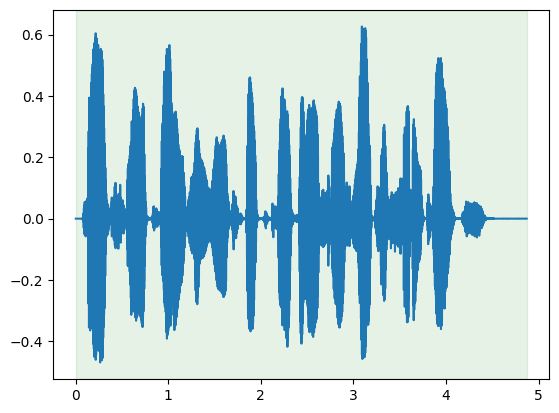

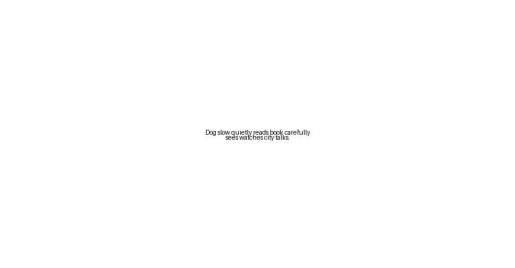

In [7]:
example_image_cut = loaded_image_cut_set[0]
audio_samples = example_image_cut.load_audio()
print(f"Audio shape: {audio_samples.shape}, sampling rate: {example_image_cut.sampling_rate}")
example_image_cut.plot_audio()

# The image is attached under the key 'visual' which we specified in attach_image
# We can load it using the dynamic `load_<key>()` method or `load_custom('<key>')`
image_pixels = example_image_cut.load_visual() # equivalent to example_image_cut.load_custom("visual")
print(f"Image shape: {image_pixels.shape} (H, W, C)")
example_image_cut.visual.plot()

text_transcription = example_image_cut.supervisions[0].text
print(f"Transcription: {text_transcription}")

example_image_cut.play_audio()

### 1.4 Building a DataLoader for Image+Audio+Text

We define a `Dataset` class that receives a batch of `cuts` (complete metadata for each example),
loads data inside `collate_*` functions, and converts them to a batched tensors.
This dataset could be further expanded to accept a tokenizer and convert the text to tokens in real applications. 

Image Batch keys: dict_keys(['id', 'audio', 'audio_lens', 'image', 'text'])
Audio batch type: <class 'torch.Tensor'>, Image batch shape: torch.Size([2, 400, 800, 3])
Audio batch shape: torch.Size([2, 128448])
Texts: ['Drives happy jumps quietly creates computer tree carefully small reads.', 'City suddenly talks tree smart creates green happy builds slow.']


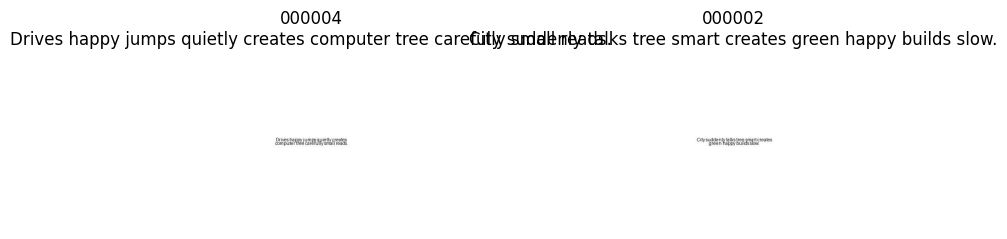

In [8]:
from torch.utils.data import Dataset, DataLoader
from lhotse.dataset.collation import collate_audio, collate_images

class ImageAudioTextTorchDataset(Dataset):
    def __getitem__(self, cuts):        
        audio, audio_lens = collate_audio(cuts)
        images = collate_images(cuts, "visual")
        texts = [cut.supervisions[0].text for cut in cuts]
        return {"id": list(cuts.ids), "audio": audio, "audio_lens": audio_lens, "image": images, "text": texts}

image_dataloader = DataLoader(
    ImageAudioTextTorchDataset(), 
    sampler=DynamicCutSampler(
        loaded_image_cut_set, 
        max_cuts=2,
        shuffle=True,
    ),
    batch_size=None,  # handled by the sampler
)

batch = next(iter(image_dataloader))
print(f"Image Batch keys: {batch.keys()}")
print(f"Audio batch type: {type(batch['audio'])}, Image batch shape: {batch['image'].shape}")
if isinstance(batch['audio'], torch.Tensor): print(f"Audio batch shape: {batch['audio'].shape}")
print(f"Texts: {batch['text']}")


fig, axes = plt.subplots(1, batch['image'].shape[0], figsize=(10,5))
if batch['image'].shape[0] == 1: axes = [axes] # Make iterable for single item batch
for i in range(batch['image'].shape[0]):
    axes[i].imshow(batch['image'][i].numpy())
    axes[i].set_title(f"{batch['id'][i]}\n{batch['text'][i]}")
    axes[i].axis('off')
plt.show()


## 2. Working with Videos

Lhotse supports videos by storing `VideoInfo` in the `Recording` manifest. The actual video frames are loaded using `torchaudio` or other libraries when needed.

### 2.1 Creating Lhotse Manifests for Videos

For videos, the `Recording` manifest will include a `VideoInfo` object. We'll use `torchaudio` to get video metadata if available, otherwise, we might need to provide it manually or use other tools.

In [9]:
video_cuts = []

for i in range(DATASET_SIZE):
    stem = f"{EXAMPLE_ROOT}/{i:06d}"
    
    recording = Recording.from_file(stem + ".mp4")
    
    cut = recording.to_cut()
    
    supervision = SupervisionSegment(
        id=recording.id,
        recording_id=recording.id,
        start=0,
        duration=recording.duration,
        channel=0,
        text=open(stem + ".txt").read().strip(),
    )
    cut.supervisions.append(supervision)
    
    video_cuts.append(cut)

video_cut_set = CutSet.from_cuts(video_cuts)

print(f"Created CutSet with {len(video_cut_set)} cut for video.")
print(f"Video cut has video: {video_cut_set[0].has_video}, VideoInfo: {video_cut_set[0].video}")

Created CutSet with 10 cut for video.
Video cut has video: True, VideoInfo: VideoInfo(fps=24.0, num_frames=24, height=480, width=640)


### 2.2 Saving and Loading Video Manifests

In [10]:

video_manifest_path = EXAMPLE_ROOT / "video_cuts.jsonl.gz"
video_cut_set.to_file(video_manifest_path)
print(f"Video CutSet saved to: {video_manifest_path}")

loaded_video_cut_set = CutSet.from_file(video_manifest_path)
print(f"Loaded CutSet with {len(loaded_video_cut_set)} video cuts.")
print(f"First loaded video cut's VideoInfo: {loaded_video_cut_set[0].video}")

Video CutSet saved to: data/synth-audio-image-video-caption/video_cuts.jsonl.gz
Loaded CutSet with 10 video cuts.
First loaded video cut's VideoInfo: VideoInfo(fps=24.0, num_frames=24, height=480, width=640)


### 2.3 Loading Video Data Items from Cuts

Loading video frames requires `torchaudio` and its dependencies (like FFmpeg). Lhotse provides `cut.load_video()`.

Attempting to load video for cut: 000000
Video frames shape: torch.Size([24, 3, 480, 640]) (T, C, H, W)


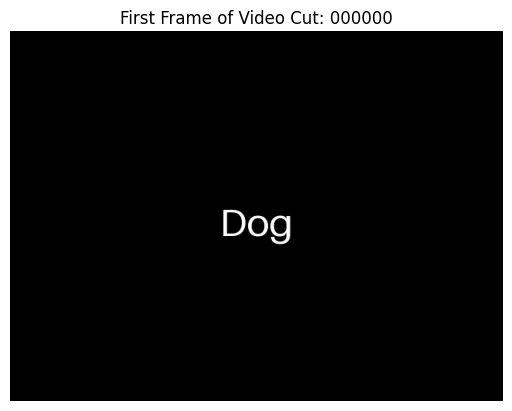

Video Transcription: Dog slow quietly reads book carefully sees watches city talks.


In [11]:
example_video_cut = loaded_video_cut_set[0]
print(f"Attempting to load video for cut: {example_video_cut.id}")

video_frames, _ = example_video_cut.load_video(with_audio=False)  # this video has no audio.
print(f"Video frames shape: {video_frames.shape} (T, C, H, W)")
plt.imshow(video_frames[0].permute(1, 2, 0).numpy()) # Display first frame
plt.title(f"First Frame of Video Cut: {example_video_cut.id}")
plt.axis('off')
plt.show()
    
video_text_transcription = example_video_cut.supervisions[0].text
print(f"Video Transcription: {video_text_transcription}")

### 2.4 Building a DataLoader for Video+Audio+Text

Similar to images, we can create a DataLoader for video-text data. 
This example can be further extended with audio support, provided the input videos have an audio channel.

Video Batch keys: dict_keys(['id', 'video', 'video_len', 'text'])
Video batch shape: torch.Size([2, 24, 3, 480, 640])
Video lengths: tensor([24, 24], dtype=torch.int32)
Texts: ['Drives happy jumps quietly creates computer tree carefully small reads.', 'City suddenly talks tree smart creates green happy builds slow.']


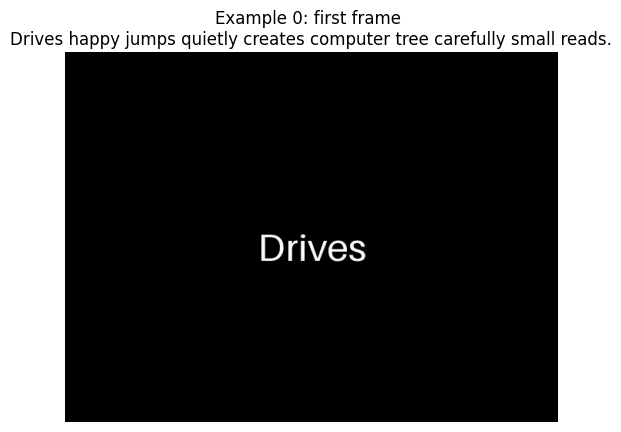

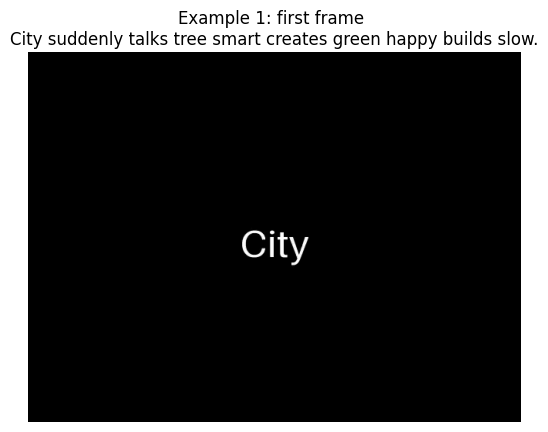

In [12]:
from lhotse.dataset.collation import collate_video


class VideoTextTorchDataset(Dataset):
    def __getitem__(self, cuts):
        video, video_len, audio, audio_len = collate_video(cuts, with_audio=False)
        assert audio is None and audio_len is None
        text = [cut.supervisions[0].text for cut in cuts]
        return {"id": cut.id, "video": video, "video_len": video_len, "text": text}


video_dataloader = DataLoader(
    VideoTextTorchDataset(), 
    sampler=DynamicCutSampler(
        loaded_video_cut_set, 
        max_cuts=2,
        shuffle=True,
    ),
    batch_size=None,  # handled by the sampler
)

video_batch = next(iter(video_dataloader))
print(f"Video Batch keys: {video_batch.keys()}")
print(f"Video batch shape: {video_batch['video'].shape}")
print(f"Video lengths: {video_batch['video_len']}")
print(f"Texts: {video_batch['text']}")

for batch_idx in range(video_batch['video'].shape[0]):
    first_video_in_batch = video_batch['video'][batch_idx]
    plt.imshow(first_video_in_batch[0].permute(1,2,0).cpu().numpy()) # First frame, CHW to HWC
    plt.title(f"Example {batch_idx}: first frame \n{video_batch['text'][batch_idx]}")
    plt.axis('off')
    plt.show()

## Conclusion

This notebook demonstrated Lhotse's capabilities for handling image and video data alongside traditional audio and text. Key takeaways:

- **Images**: `MonoCut.attach_image()` simplifies associating images with cuts. The `Image` manifest stores metadata, and `cut.load_<key>()` or `cut.load_custom('<key>')` loads the image as a NumPy array.
- **Videos**: `Recording.from_file(..., video_path=...)` associates a video file. `VideoInfo` within the `Recording` holds video metadata. `cut.load_video()` loads video frames (and optionally audio from the video file) using `torchaudio`. 
- **Flexibility**: Lhotse's manifest system and custom attributes provide a flexible way to manage diverse multimedia datasets.
- **DataLoading**: Standard PyTorch `Dataset` and `DataLoader` can be used, but custom collation is often necessary for multimedia data, especially to handle padding of variable-length audio/video sequences.

Remember that for video processing, having `torchaudio` compiled with FFmpeg support is crucial for robust metadata extraction and frame loading across various video formats.